In [1]:
import pybamm;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;
import matplotlib as mpl; 
fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

In [2]:
import sys  
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\Rio_Code\Fun_P3"))
sys.path.append(str_path_1) 
from Fun_P3 import (
    PlotDynamics,
    Plot_Loc_Var,
    Plot_Loc_Var_sol,
    Plot_Single_Static,
    RioCallback,
    recursive_scan,
    Para_init,
    write_excel_xlsx,
    Run_P3_model,
    Plot_Last_Single_Step,
    GetSol_dict,
    Plot_Loc_Var_2,
    Plot_Fig_1,
    Plot_Loc_Var_sol_6,
)

In [13]:
########################  Input  ########################
# all values here must be a list, even it is a single object
Para_dict_All = {
   "Total ageing cycles":[300,],
   "SaveAsList":[  [100,10,1,1,1,1],  ],
   "Ageing temperature":[25,],
   #"Particle mesh points":[120,],
   #"Exponential mesh stretch":[2.3,],
   "Para_Set":[ "Li2023_ECdrag",],
    
    "Model option":[
        {
            #"calculate discharge energy":"true",
            "SEI":"interstitial-diffusion limited",          
            "SEI film resistance":"distributed",          
            "SEI porosity change":"true",     
            "solvent diffusion": "double spatial consume w refill"   },
    ],
   # solvent diffusion parameters:
   "EC transference number":[-1.4,],
   "Cation transference number":[0.28,],
   "EC Lithium ion cross diffusivity [m2.s-1]":[3e-11,],
   "EC diffusivity in electrolyte [m2.s-1]":[3.2e-10,],

   # DFN parameter
   "Upper voltage cut-off [V]":[4.21,],
   "Lower voltage cut-off [V]":[2.49,],
   #"Negative electrode diffusivity [m2.s-1]":[2e-13,],
   #"Positive electrode diffusivity [m2.s-1]":[1e-13,],
   # if want a function, add 'Func', 
   #    if want a constant, delete Func
   # note!!!: Constant will overwrite Func
   "Func Electrolyte conductivity [S.m-1]":[
        "electrolyte_conductivity_Valoen2005Constant_wEC_Haya",],
    "Func Electrolyte diffusivity [m2.s-1]":[
        "electrolyte_diffusivity_Valoen2005Constant",],
   # general SEI
   'SEI resistivity [Ohm.m]':[2E5,],
   "Ratio of lithium moles to SEI moles":[2,],
   "Inner SEI reaction proportion":[0.0,],
   "Initial inner SEI thickness [m]":[2.5e-9,],
   "Initial outer SEI thickness [m]":[2.5e-9,],
   # solvent-diffusion limited
   'Outer SEI solvent diffusivity [m2.s-1]':[1.7e-22,],
   'Bulk solvent concentration [mol.m-3]':[4541.0,],
   # interstitial-diffusion limited
   'Inner SEI lithium interstitial diffusivity [m2.s-1]':[3e-19,3e-18,3e-17],    
   'Lithium interstitial reference concentration [mol.m-3]':[15,],
   # ec-reaction limited
   'EC diffusivity in SEI [m2.s-1]':[2e-20],
   'SEI kinetic rate constant [m.s-1]':[1e-19,],
   'EC initial concentration in electrolyte [mol.m-3]':[4541.0,],
}
Para_dict_list = []
recursive_scan(Para_dict_list,Para_dict_All, list(Para_dict_All.keys()), {})

In [14]:
print(len(Para_dict_list))

3


In [15]:
keys_loc_AGE = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Negative electrode porosity",
    "CCend Positive electrode potential [V]",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend EC concentration [mol.m-3]",
    "CCend c(EC) over c(Li+)",
    "CCend Electrolyte current density [A.m-2]",
    "CCend Electrolyte diffusivity [m2.s-1]",
    "CCend Electrolyte conductivity [S.m-1]",
    "CCend Negative electrode SEI interfacial current density [A.m-2]",

    "CDend Negative electrode porosity",
    "CDend Positive electrode potential [V]",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend EC concentration [mol.m-3]",
    "CDend c(EC) over c(Li+)",
    "CDend Electrolyte current density [A.m-2]",
    "CDend Electrolyte diffusivity [m2.s-1]",
    "CDend Electrolyte conductivity [S.m-1]",
    "CDend Negative electrode SEI interfacial current density [A.m-2]",

]
keys_tim_AGE = [
    # default: CD
    "CD Time [h]",
    "CC Time [h]",
    "CV Time [h]",
    "CD Terminal voltage [V]",
    "CC Terminal voltage [V]",
    "RE Terminal voltage [V]",
]
keys_cyc_AGE = [   # default: CDend
    "Discharge capacity [A.h]",
    "CDend Loss of capacity to SEI [A.h]",
    "CDend Local ECM resistance [Ohm]",
    "CDsta Negative electrode SOC", 
    "CDend Negative electrode SOC",
    "CDsta Positive electrode SOC", 
    "CDend Positive electrode SOC",
    "CDend Negative electrode capacity [A.h]",
    "CDend Positive electrode capacity [A.h]",
]
keys_all_AGE = [keys_loc_AGE,keys_tim_AGE,keys_cyc_AGE];

In [16]:
# define experiments and scan!
V_max = 4.2;        V_min = 2.5; 
exp_AGE = [
   (f"Discharge at 1 C until {V_min} V", 
   f"Charge at 1 C until {V_max} V",  # (5 minute period)
   f"Hold at {V_max} V until C/20"),  ]# (5 minute period)
exp_AGE_2 = [
   (f"Discharge at 1 C until {V_min} V (5 seconds period)", 
   f"Charge at 1 C until {V_max} V (5 seconds period)", 
   f"Hold at {V_max} V until C/20 (5 seconds period)"),]
# step index for ageing
exp_AGE_CD = [ (
   f"Discharge at 1 C until {V_min} V (1 seconds period)",   ) ]
exp_AGE_CC = [ (
   f"Charge at 1 C until {V_max} V (1 seconds period)" ) ]
exp_AGE_CV = [ (
   f"Hold at {V_max} V until C/20 (1 seconds period)" ) ]
step_AGE_CD =0;   step_AGE_CC =1;   step_AGE_CV =2;

Exp_AGE_List     = [
    exp_AGE,exp_AGE,exp_AGE_2,
    exp_AGE_CD,exp_AGE_CC,exp_AGE_CV];
cycle_no = -1; 
exp_index_pack = [
   cycle_no,step_AGE_CD,
   step_AGE_CC,step_AGE_CV,];
# Path and save to excel
BasicPath = 'D:/OneDrive - Imperial College London/SimDataSave/P3R9/'; 
Target  = 'c1_ec_scan_v2/' 
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target);
book_name_xlsx = 'c1_ec_scan_v2.xlsx';sheet_name_xlsx = 'Results';
Path_pack = [BasicPath,Target,book_name_xlsx,sheet_name_xlsx,];
# Write the head for excel file:
head_list = list(Para_dict_list[0].keys())
head_list.insert(0,"Index");
head_list.extend([ "exp_AGE_text", 
   "Cap Loss","LLI to SEI",
   "LAM to Neg","LAM to Pos",
   "Error"])
write_excel_xlsx(
    BasicPath + Target+book_name_xlsx, 
    sheet_name_xlsx, [head_list])
# scan:
index_xlsx = 0;      
Sol_All_All = [];        Succ_Cyc_All = [];   
Index_single_step = [];  Para_dict_succ = [];
for Para_dict_i in Para_dict_list:
   index_xlsx += 1;
   print(f"Scan No. {index_xlsx} Start:")
   Sol_All,Succ_Cyc = Run_P3_model(
      index_xlsx, Para_dict_i,   Path_pack , 
      keys_all_AGE,   Exp_AGE_List, exp_index_pack )
   # can add judgement of single steps here, if single steps starts from 3 is fine
   # only when Index_single_step[i]>3, add, 
   #      otherwise, discard results and print("degrade too fast")
   # add Para_dict_succ
   j=0;
   while j <len(Sol_All):
        if len(Sol_All[j].cycles[-1].steps)==1:
            break
        j += 1
   if j < len(Sol_All):
        print("Single step starts from %d" %j)
   elif j==len(Sol_All):
        
        print("No single step")
   else:
        pass
   if j > 3:
      Sol_All_All.append(Sol_All)
      Succ_Cyc_All.append(Succ_Cyc)
      Para_dict_succ.append(Para_dict_i)
      Index_single_step.append(j)
      print(f"Scan No. {index_xlsx} succeed!")
   else:
      print("Degrade too fast!")


Successfully create a excel file
This is Scan No. 1
Confirm: using interstitial-diffusion limited
try to run 100 cycles
Succeed! Now it is the 100th cycles
try to run 100 cycles
Succeed! Now it is the 200th cycles
try to run 100 cycles


At t = 0.00435624, , mxstep steps taken before reaching tout.
At t = 0.00435624, , mxstep steps taken before reaching tout.
At t = 0.00185628, , mxstep steps taken before reaching tout.
At t = 0.000606216, , mxstep steps taken before reaching tout.
At t = 0.000606211, , mxstep steps taken before reaching tout.
At t = 0.000293696, , mxstep steps taken before reaching tout.
At t = 0.000137439, , mxstep steps taken before reaching tout.
At t = 5.93098e-005, , mxstep steps taken before reaching tout.
At t = 2.02495e-005 and h = 2.55415e-025, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 1.54476e-005, , mxstep steps taken before reaching tout.
At t = 1.54476e-005, , mxstep steps taken before reaching tout.
At t = 1.54476e-005 and h = 1.98672e-025, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 1.54476e-005, , mxstep steps taken before reaching tout.
At t = 1.54476e-005, , mxstep steps taken before reaching tout.
At t = 1.54476e-005 and h = 1.

Failed and shorten cycles
try to run 10 cycles
Succeed! Now it is the 210th cycles
try to run 10 cycles
Succeed! Now it is the 220th cycles
try to run 10 cycles
Succeed! Now it is the 230th cycles
try to run 10 cycles
Succeed! Now it is the 240th cycles
try to run 10 cycles
Succeed! Now it is the 250th cycles
try to run 10 cycles


At t = 0.00435622, , mxstep steps taken before reaching tout.
At t = 0.00435627, , mxstep steps taken before reaching tout.
At t = 0.00185627, , mxstep steps taken before reaching tout.
At t = 0.00060627, , mxstep steps taken before reaching tout.
At t = 0.000606269, , mxstep steps taken before reaching tout.
At t = 0.000293759, , mxstep steps taken before reaching tout.
At t = 0.00013751, , mxstep steps taken before reaching tout.
At t = 5.93835e-005 and h = 6.87382e-026, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 2.03208e-005, , mxstep steps taken before reaching tout.
At t = 1.54504e-005, , mxstep steps taken before reaching tout.
At t = 1.54504e-005, , mxstep steps taken before reaching tout.
At t = 1.54504e-005, , mxstep steps taken before reaching tout.
At t = 1.54504e-005, , mxstep steps taken before reaching tout.
At t = 1.54504e-005, , mxstep steps taken before reaching tout.
At t = 1.54504e-005 and h = 8.03099e-026, the corrector convergence failed

Failed and shorten cycles
try to run 1 cycles
Succeed! Now it is the 251th cycles
try to run 1 cycles
Succeed! Now it is the 252th cycles
try to run 1 cycles
Succeed! Now it is the 253th cycles
try to run 1 cycles
Succeed! Now it is the 254th cycles
try to run 1 cycles
Succeed! Now it is the 255th cycles
try to run 1 cycles


At t = 0.00965298, , mxstep steps taken before reaching tout.
At t = 0.00480584, , mxstep steps taken before reaching tout.
At t = 0.000399147, , mxstep steps taken before reaching tout.
At t = 0.000399145, , mxstep steps taken before reaching tout.
At t = 0.000399147 and h = 1.68792e-026, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 8.66486e-005, , mxstep steps taken before reaching tout.
At t = 8.66486e-005, , mxstep steps taken before reaching tout.
At t = 1.54992e-005, , mxstep steps taken before reaching tout.
At t = 1.54992e-005 and h = 2.11661e-024, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 1.54992e-005, , mxstep steps taken before reaching tout.
At t = 1.54992e-005 and h = 6.44248e-026, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 1.54992e-005, , mxstep steps taken before reaching tout.
At t = 1.54992e-005, , mxstep steps taken before reaching tout.
2022-11-02 16:58:56.714 - [ERROR] callbacks.on_ex

Failed and shorten cycles
try to run 1 cycles
Succeed! Now it is the 256th cycles
Succeed a single step and switch to next step normally
try to run 1 cycles


At t = 0.00806605, , mxstep steps taken before reaching tout.
At t = 0.00313056, , mxstep steps taken before reaching tout.
At t = 0.000662823 and h = 2.35047e-027, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.000662833, , mxstep steps taken before reaching tout.
At t = 4.59021e-005 and h = 2.34413e-026, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 4.59021e-005 and h = 8.86041e-028, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 4.59021e-005, , mxstep steps taken before reaching tout.
At t = 4.59021e-005, , mxstep steps taken before reaching tout.


Succeed! Now it is the 257th cycles
Succeed a single step and switch to next step normally
try to run 1 cycles


At t = 1.54917e-005, , mxstep steps taken before reaching tout.
At t = 1.54917e-005, , mxstep steps taken before reaching tout.
At t = 1.54917e-005, , mxstep steps taken before reaching tout.
At t = 1.54917e-005 and h = 5.09787e-026, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 1.54917e-005, , mxstep steps taken before reaching tout.
At t = 1.54917e-005, , mxstep steps taken before reaching tout.
2022-11-02 17:02:47.482 - [ERROR] callbacks.on_experiment_error(226): Simulation error: Maximum number of decreased steps occurred at t=0.0 (final SolverError: '.../casadi/interfaces/sundials/idas_interface.cpp:591: IDASolve returned "IDA_TOO_MUCH_WORK". Consult IDAS documentation.'). For a full solution try reducing dt_max (currently, dt_max=113.46612775644178) and/or reducing the size of the time steps or period of the experiment. Set `return_solution_if_failed_early=True` to return the solution object up to the point where failure occured.


Failed and shorten cycles
Exit as no options left
Finally finish 257 cycles
This is Scan No. 2
Confirm: using interstitial-diffusion limited
try to run 100 cycles
Succeed! Now it is the 100th cycles
try to run 100 cycles


At t = 0.00527379, , mxstep steps taken before reaching tout.
At t = 0.000273753, , mxstep steps taken before reaching tout.
At t = 0.000273755, , mxstep steps taken before reaching tout.
At t = 0.000273755, , mxstep steps taken before reaching tout.
At t = 0.000273754, , mxstep steps taken before reaching tout.
At t = 0.000273755 and h = 1.57106e-026, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.000117501, , mxstep steps taken before reaching tout.
At t = 3.93738e-005 and h = 1.33753e-029, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 3.11442e-007, , mxstep steps taken before reaching tout.
At t = 3.11442e-007, , mxstep steps taken before reaching tout.
At t = 3.11442e-007, , mxstep steps taken before reaching tout.
At t = 3.11442e-007 and h = 1.76682e-026, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 3.114e-007 and h = 6.15037e-027, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 3.1

Failed and shorten cycles
try to run 10 cycles
Succeed! Now it is the 110th cycles
try to run 10 cycles
Succeed! Now it is the 120th cycles
try to run 10 cycles


At t = 0.0052737, , mxstep steps taken before reaching tout.
At t = 0.000273915, , mxstep steps taken before reaching tout.
At t = 0.000273921 and h = 5.28108e-027, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.000273919 and h = 2.59055e-027, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00027392, , mxstep steps taken before reaching tout.
At t = 0.000273923, , mxstep steps taken before reaching tout.
At t = 0.000117675, , mxstep steps taken before reaching tout.
At t = 3.95466e-005, , mxstep steps taken before reaching tout.
At t = 4.84086e-007, , mxstep steps taken before reaching tout.
At t = 4.84086e-007, , mxstep steps taken before reaching tout.
At t = 4.84086e-007, , mxstep steps taken before reaching tout.
At t = 4.84086e-007, , mxstep steps taken before reaching tout.
At t = 4.84084e-007, , mxstep steps taken before reaching tout.
At t = 4.84085e-007, , mxstep steps taken before reaching tout.
2022-11-02 17:21:14.624 - [ERR

Failed and shorten cycles
try to run 1 cycles
Succeed! Now it is the 121th cycles
try to run 1 cycles
Succeed! Now it is the 122th cycles
try to run 1 cycles
Succeed! Now it is the 123th cycles
try to run 1 cycles
Succeed! Now it is the 124th cycles
try to run 1 cycles
Succeed! Now it is the 125th cycles
try to run 1 cycles
Succeed! Now it is the 126th cycles
try to run 1 cycles
Succeed! Now it is the 127th cycles
try to run 1 cycles
Succeed! Now it is the 128th cycles
try to run 1 cycles


At t = 0.00265661, , mxstep steps taken before reaching tout.
At t = 0.00265656, , mxstep steps taken before reaching tout.
At t = 0.000453247, , mxstep steps taken before reaching tout.
At t = 0.000453238 and h = 1.50297e-027, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 1.25844e-005, , mxstep steps taken before reaching tout.
At t = 1.25844e-005 and h = 1.81262e-027, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 1.25844e-005, , mxstep steps taken before reaching tout.
At t = 1.25844e-005, , mxstep steps taken before reaching tout.
At t = 1.25844e-005 and h = 2.96089e-027, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 1.25844e-005, , mxstep steps taken before reaching tout.
2022-11-02 17:24:35.203 - [ERROR] callbacks.on_experiment_error(226): Simulation error: Maximum number of decreased steps occurred at t=3601.703638198622 (final SolverError: '.../casadi/interfaces/sundials/idas_interface.cpp:591: IDASolve r

Failed and shorten cycles
try to run 1 cycles
Succeed! Now it is the 129th cycles
Succeed a single step and switch to next step normally
try to run 1 cycles


At t = 0.00186535, , mxstep steps taken before reaching tout.
At t = 0.00186537, , mxstep steps taken before reaching tout.
At t = 0.00186538, , mxstep steps taken before reaching tout.
At t = 0.000631473 and h = 3.87806e-027, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 1.45539e-005, , mxstep steps taken before reaching tout.
At t = 1.45539e-005, , mxstep steps taken before reaching tout.
At t = 1.45539e-005 and h = 6.06305e-027, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 1.45539e-005 and h = 3.88023e-027, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 1.45539e-005, , mxstep steps taken before reaching tout.
At t = 1.45539e-005, , mxstep steps taken before reaching tout.
2022-11-02 17:27:14.928 - [ERROR] callbacks.on_experiment_error(226): Simulation error: Maximum number of decreased steps occurred at t=359.99999999999994 (final SolverError: '.../casadi/interfaces/sundials/idas_interface.cpp:591: IDASolve r

Failed and shorten cycles
try to run 1 cycles


2022-11-02 17:27:16.311 - [ERROR] callbacks.on_experiment_error(226): Simulation error: Could not find consistent states: Could not find acceptable solution: .../casadi/core/rootfinder.cpp:280: rootfinder process failed. Set 'error_on_fail' option to false to ignore this error.


Failed and shorten cycles
Exit as no options left
Finally finish 129 cycles
This is Scan No. 3
Confirm: using interstitial-diffusion limited
try to run 100 cycles


At t = 0.00268716, , mxstep steps taken before reaching tout.
At t = 0.00268716, , mxstep steps taken before reaching tout.
At t = 0.000187183, , mxstep steps taken before reaching tout.
At t = 0.000187185, , mxstep steps taken before reaching tout.
At t = 0.000187181 and h = 5.84809e-027, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.000187183, , mxstep steps taken before reaching tout.
At t = 3.09317e-005, , mxstep steps taken before reaching tout.
At t = 3.09317e-005, , mxstep steps taken before reaching tout.
At t = 3.09317e-005, , mxstep steps taken before reaching tout.
At t = 1.13987e-005, , mxstep steps taken before reaching tout.
At t = 1.63308e-006, , mxstep steps taken before reaching tout.
At t = 1.63305e-006, , mxstep steps taken before reaching tout.
At t = 1.63311e-006, , mxstep steps taken before reaching tout.
At t = 4.12345e-007, , mxstep steps taken before reaching tout.
At t = 4.12333e-007 and h = 6.91757e-028, the corrector convergence fa

Failed and shorten cycles
try to run 10 cycles
Succeed! Now it is the 10th cycles
try to run 10 cycles
Succeed! Now it is the 20th cycles
try to run 10 cycles


At t = 0.00268716, , mxstep steps taken before reaching tout.
At t = 0.00268716 and h = 9.17133e-029, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.000187179, , mxstep steps taken before reaching tout.
At t = 0.000187181, , mxstep steps taken before reaching tout.
At t = 0.000187182, , mxstep steps taken before reaching tout.
At t = 0.000187178, , mxstep steps taken before reaching tout.
At t = 3.0931e-005, , mxstep steps taken before reaching tout.
At t = 3.0931e-005, , mxstep steps taken before reaching tout.
At t = 3.0931e-005, , mxstep steps taken before reaching tout.
At t = 1.13982e-005, , mxstep steps taken before reaching tout.
At t = 1.63257e-006, , mxstep steps taken before reaching tout.
At t = 1.63254e-006, , mxstep steps taken before reaching tout.
At t = 1.6326e-006, , mxstep steps taken before reaching tout.
At t = 4.11835e-007, , mxstep steps taken before reaching tout.
At t = 4.11825e-007 and h = 6.3183e-028, the corrector convergence failed 

Failed and shorten cycles
try to run 1 cycles
Succeed! Now it is the 21th cycles
try to run 1 cycles
Succeed! Now it is the 22th cycles
try to run 1 cycles
Succeed! Now it is the 23th cycles
try to run 1 cycles
Succeed! Now it is the 24th cycles
try to run 1 cycles
Succeed! Now it is the 25th cycles
try to run 1 cycles
Succeed! Now it is the 26th cycles
try to run 1 cycles


At t = 0.0088587, , mxstep steps taken before reaching tout.
At t = 0.00401192 and h = 2.73832e-027, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00180865, , mxstep steps taken before reaching tout.
At t = 4.59236e-005, , mxstep steps taken before reaching tout.
At t = 4.59236e-005, , mxstep steps taken before reaching tout.
At t = 4.59236e-005, , mxstep steps taken before reaching tout.
At t = 4.59236e-005, , mxstep steps taken before reaching tout.
At t = 4.59236e-005, , mxstep steps taken before reaching tout.
At t = 6.86099e-006, , mxstep steps taken before reaching tout.
At t = 6.86099e-006, , mxstep steps taken before reaching tout.
At t = 6.86115e-006, , mxstep steps taken before reaching tout.
At t = 1.97769e-006, , mxstep steps taken before reaching tout.
At t = 1.97762e-006, , mxstep steps taken before reaching tout.
At t = 7.56929e-007, , mxstep steps taken before reaching tout.
At t = 1.46589e-007, , mxstep steps taken before reaching tout.
At t 

Failed and shorten cycles
try to run 1 cycles
Succeed! Now it is the 27th cycles
Succeed a single step and switch to next step normally
try to run 1 cycles


At t = 0.00700706, , mxstep steps taken before reaching tout.
At t = 0.00207175, , mxstep steps taken before reaching tout.
At t = 0.00207175, , mxstep steps taken before reaching tout.
At t = 0.000837946 and h = 7.15829e-028, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.000221014 and h = 7.4291e-027, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.000221016, , mxstep steps taken before reaching tout.
At t = 4.47413e-005, , mxstep steps taken before reaching tout.
At t = 4.47413e-005, , mxstep steps taken before reaching tout.
At t = 5.67902e-006, , mxstep steps taken before reaching tout.
At t = 5.67902e-006, , mxstep steps taken before reaching tout.
At t = 5.67902e-006 and h = 5.74375e-027, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 7.95465e-007, , mxstep steps taken before reaching tout.
At t = 7.95493e-007 and h = 5.99379e-028, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 7.9

Succeed! Now it is the 28th cycles
Succeed a single step and switch to next step normally
try to run 1 cycles
Failed and shorten cycles
Exit as no options left
Finally finish 28 cycles


In [17]:
# find single step
Index_single_step = [];
for i in range(0,len(Sol_All_All)):
    j=0;
    while j <len(Sol_All_All[i]):
        #print(len(Sol_All_All[i][j].cycles[-1].steps))
        if len(Sol_All_All[i][j].cycles[-1].steps)==1:
            break
        j += 1
    if j < len(Sol_All_All[i]):
        Index_single_step.append(j)
        print("Single step starts from %d" %j)
    elif j==len(Sol_All_All[i]):
        Index_single_step.append(j)
        print("No single step")
    else:
        pass
for i in range(0,len(Sol_All_All)):
    for j in range(Index_single_step[i],len(Sol_All_All[i])):
        print(f"Num {j} has {len(Sol_All_All[i][j].cycles[-1].steps)} step")
 

Single step starts from 12
Single step starts from 11
Single step starts from 8
Num 12 has 1 step
Num 13 has 1 step
Num 11 has 1 step
Num 8 has 1 step
Num 9 has 1 step


Not all solution has full cycles
Not all solution has full cycles
Not all solution has full cycles


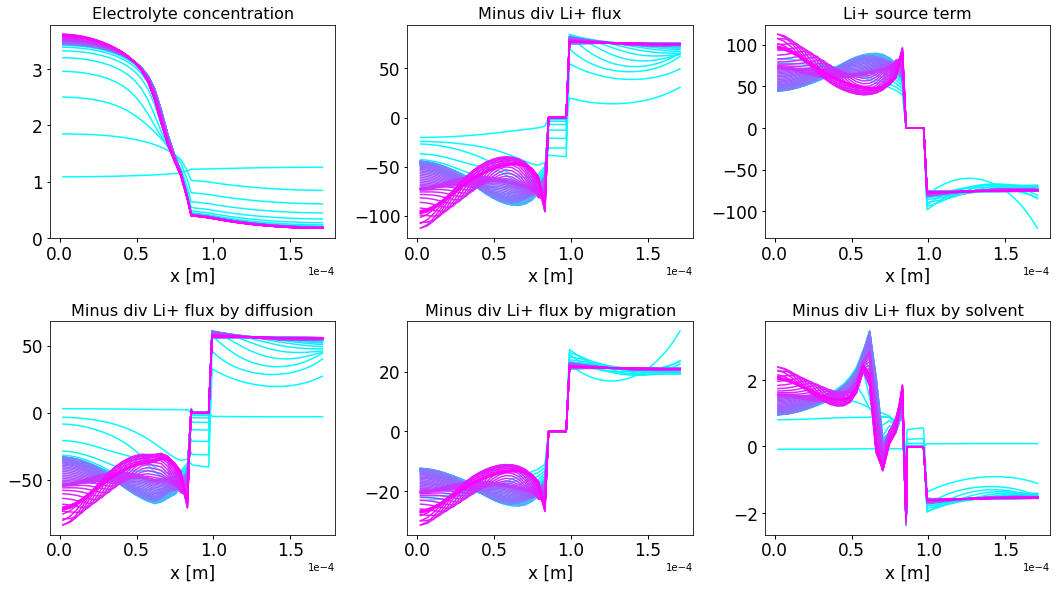

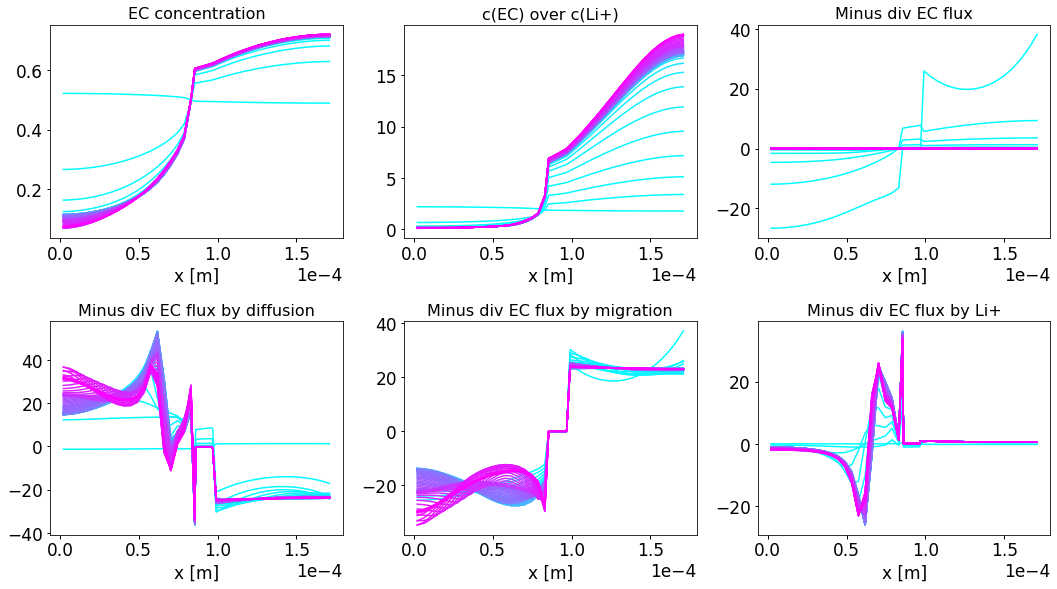

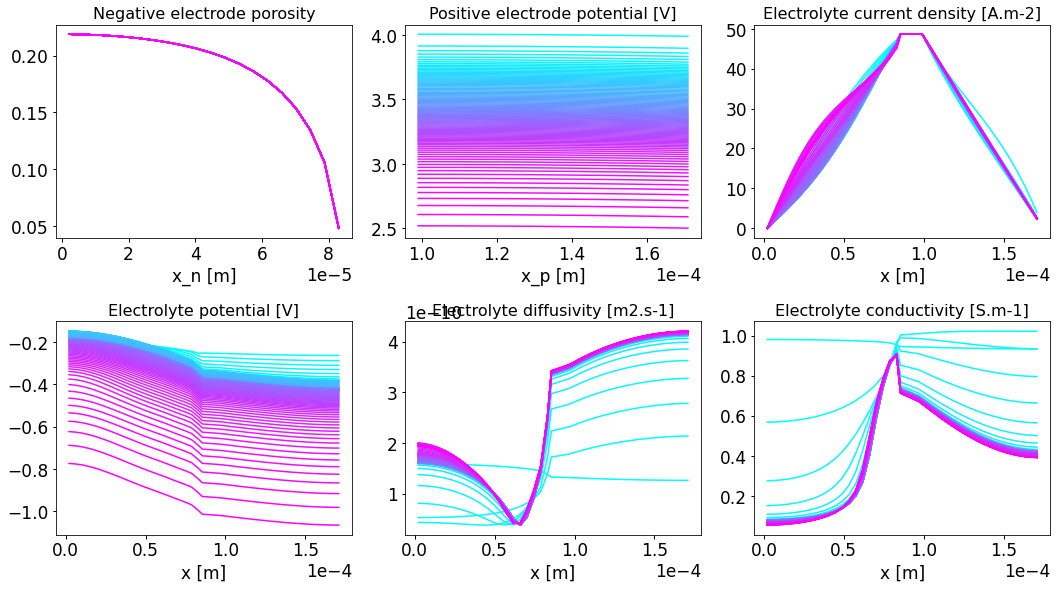

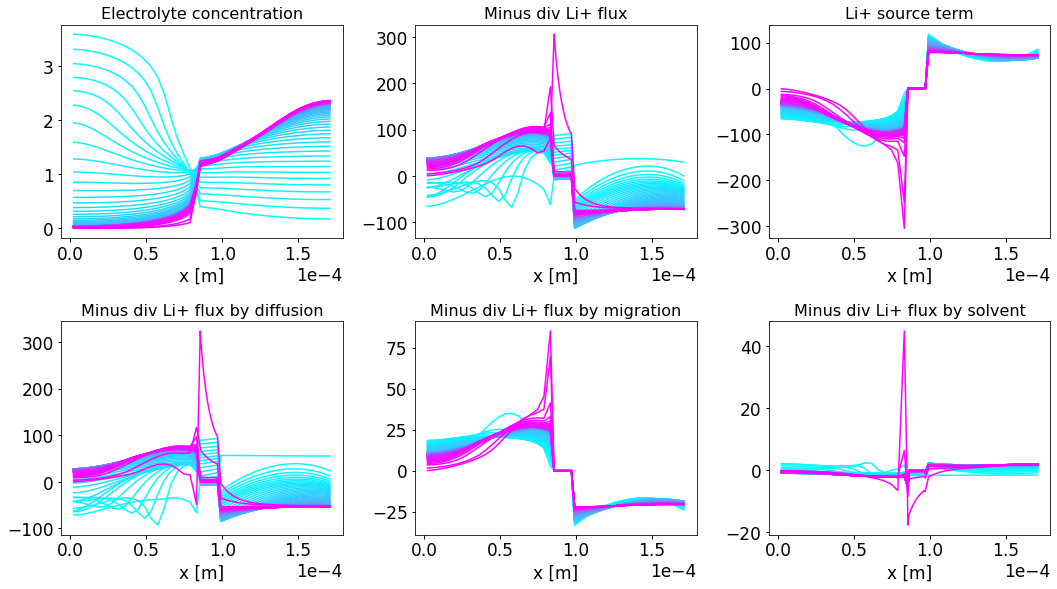

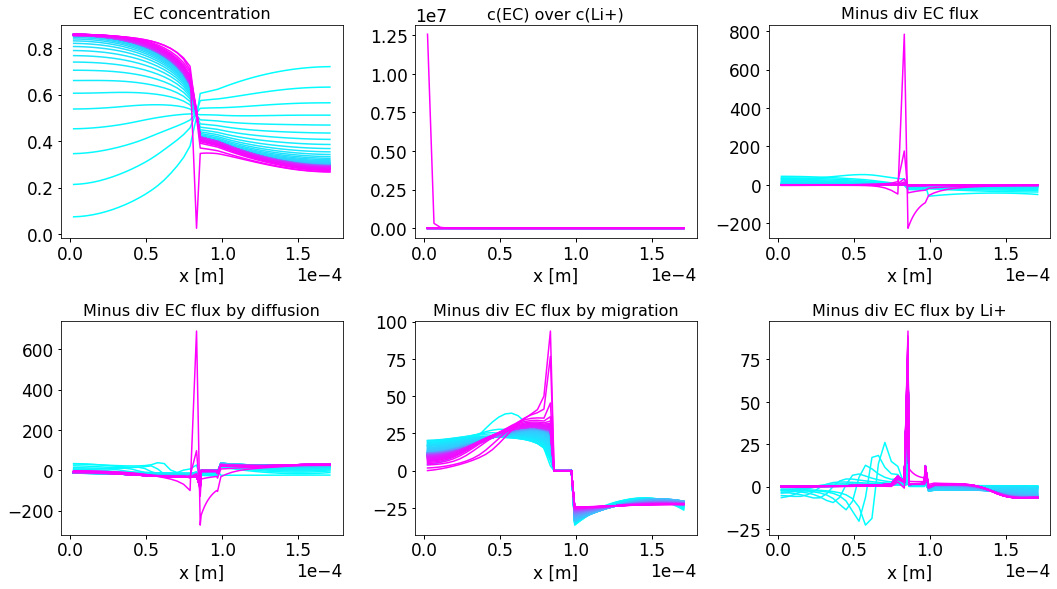

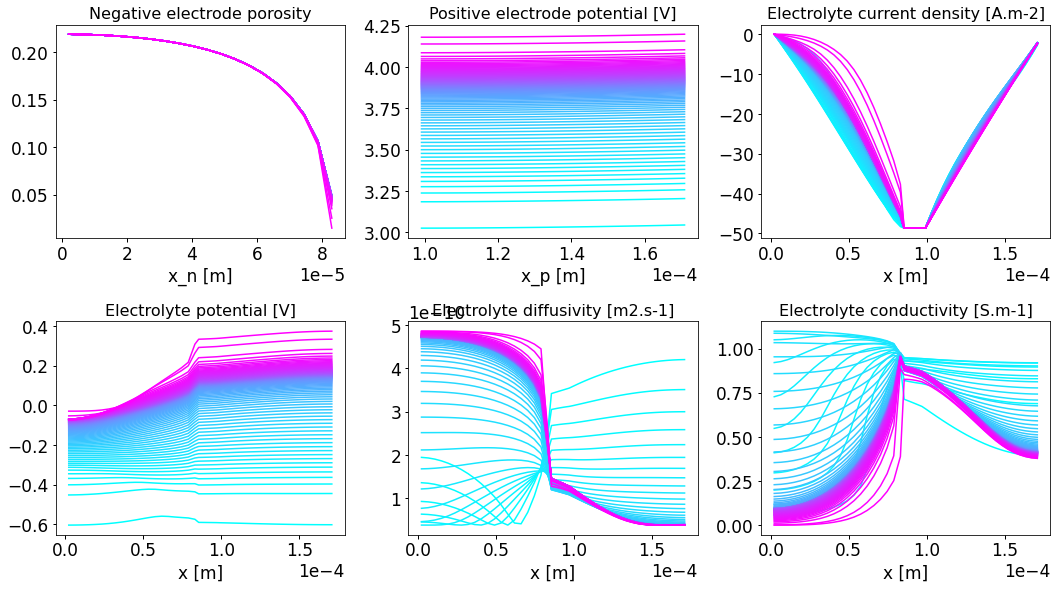

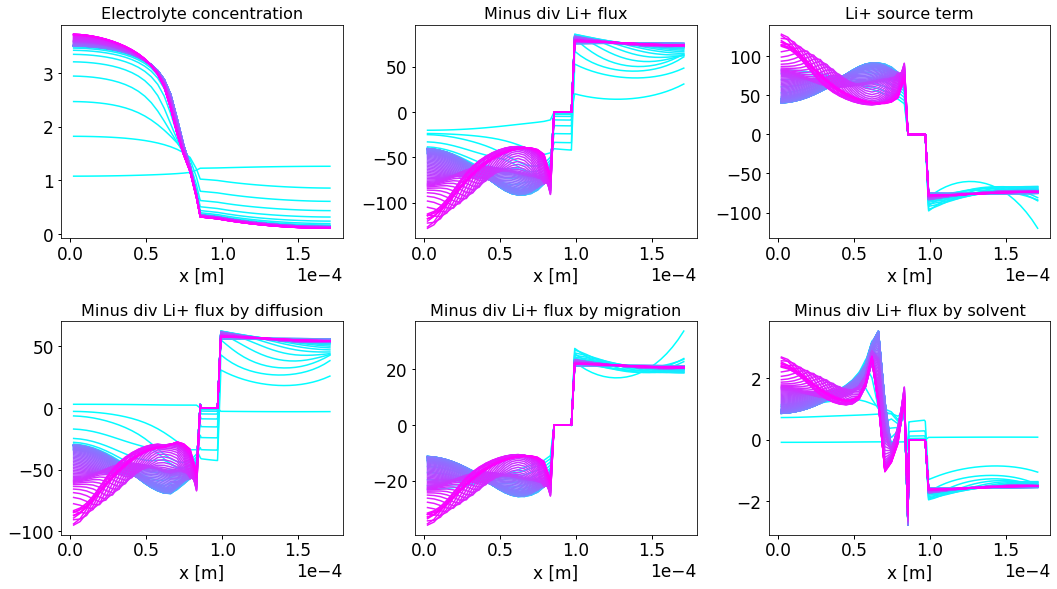

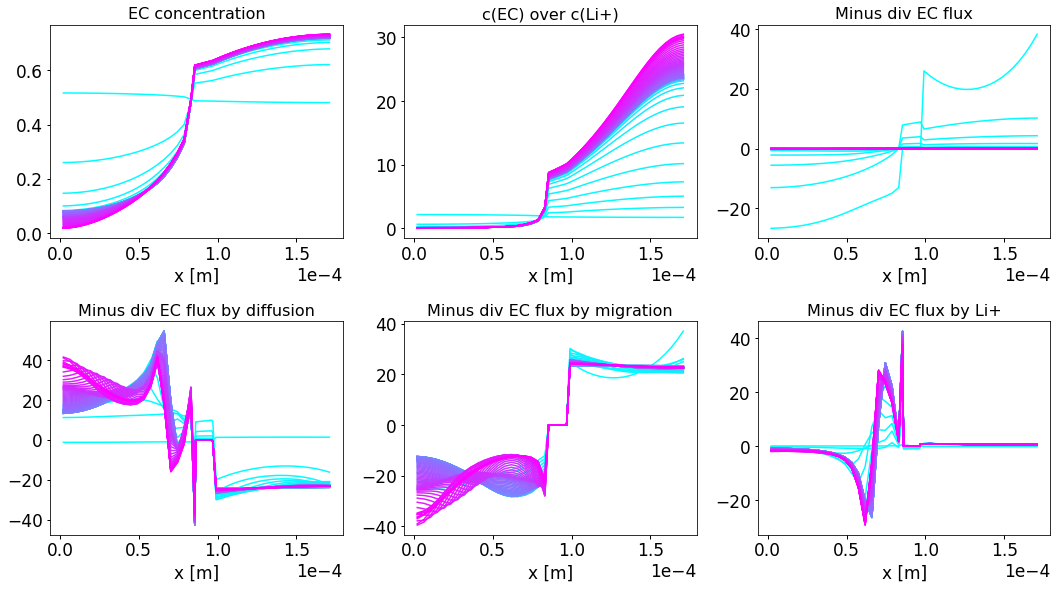

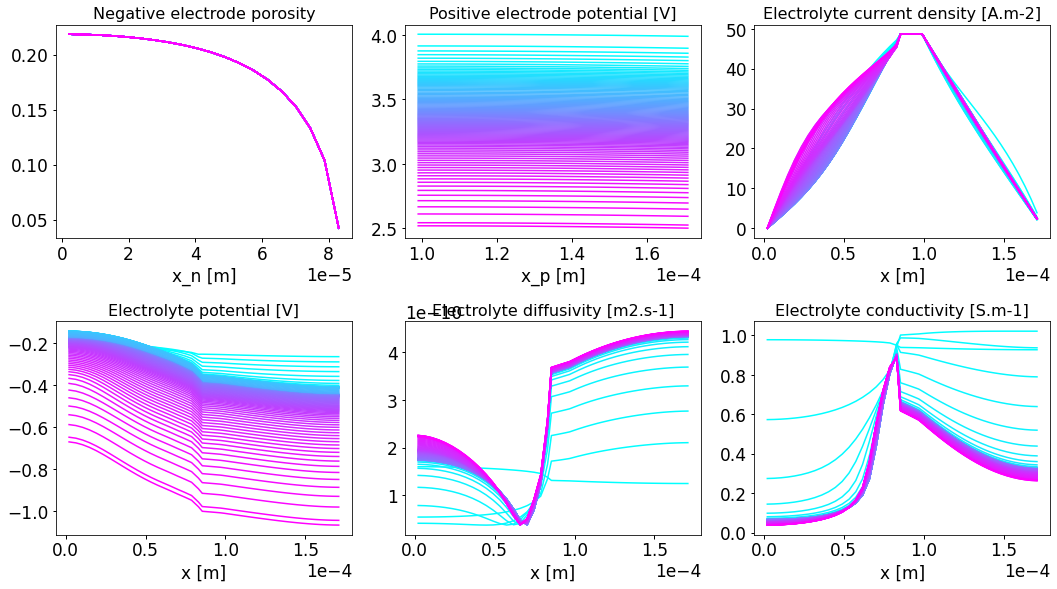

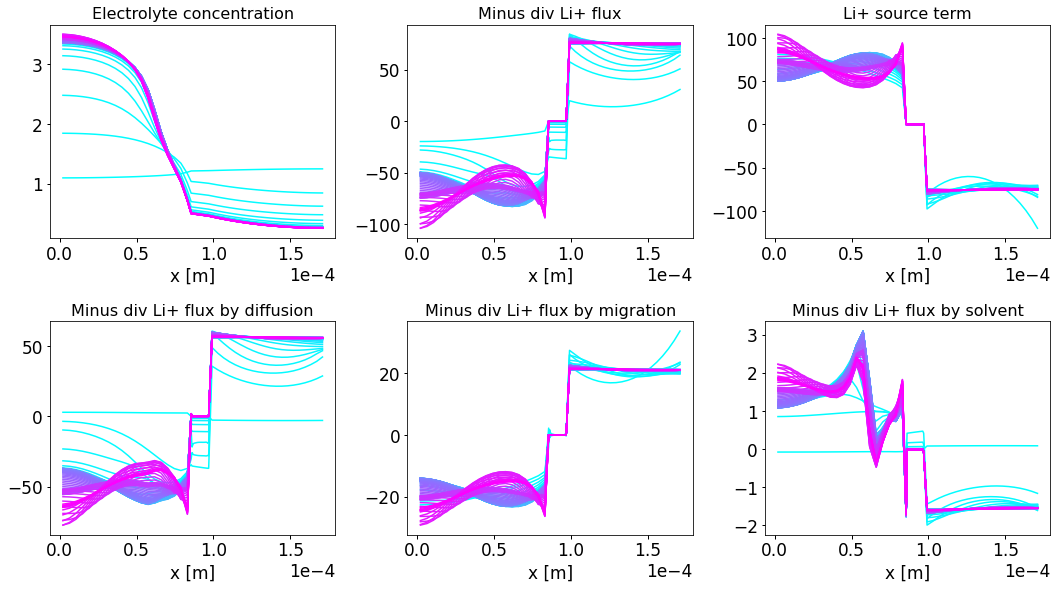

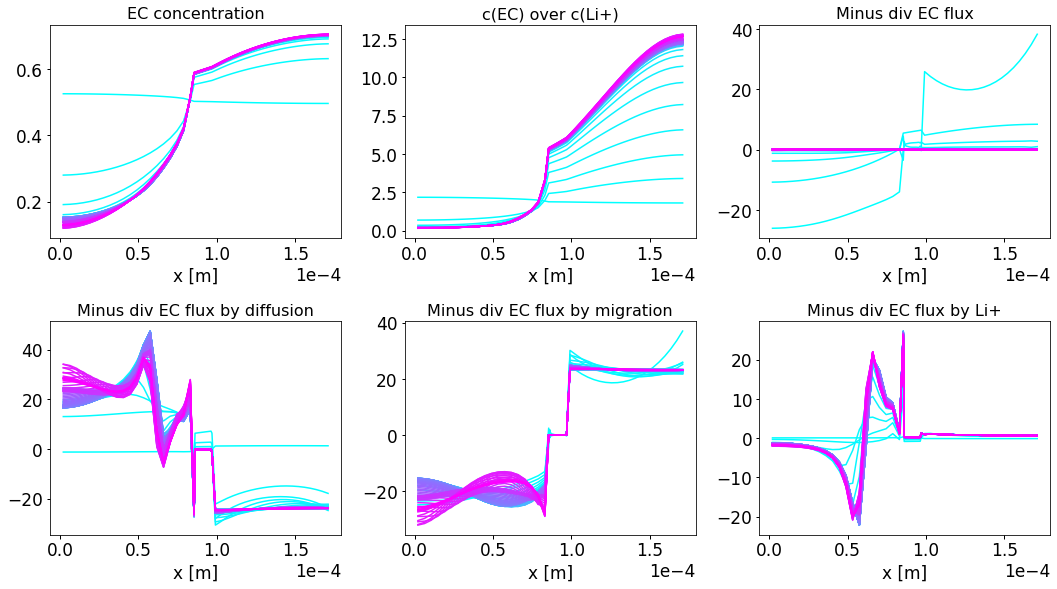

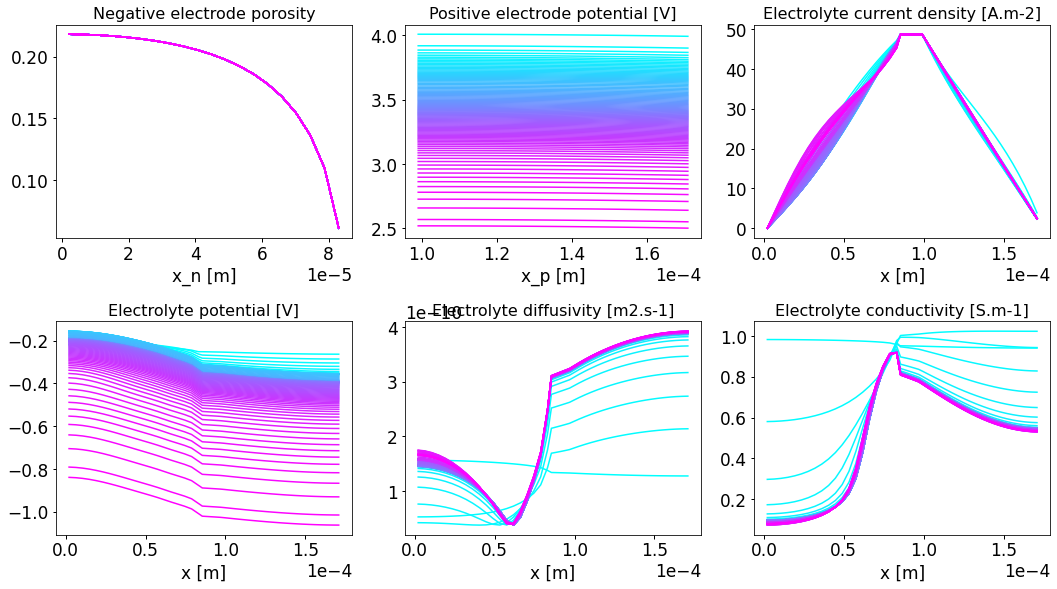

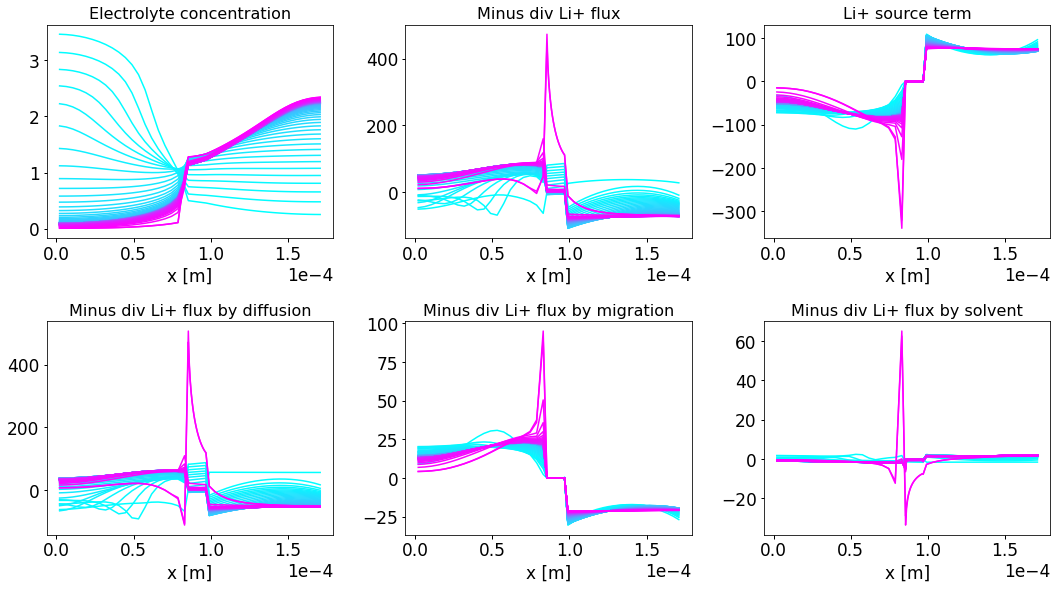

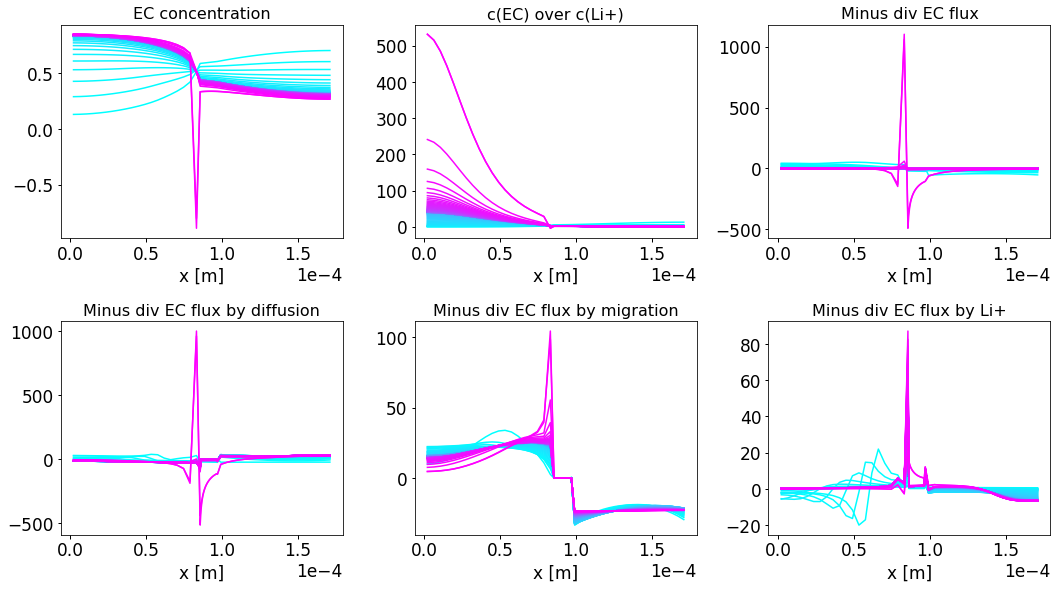

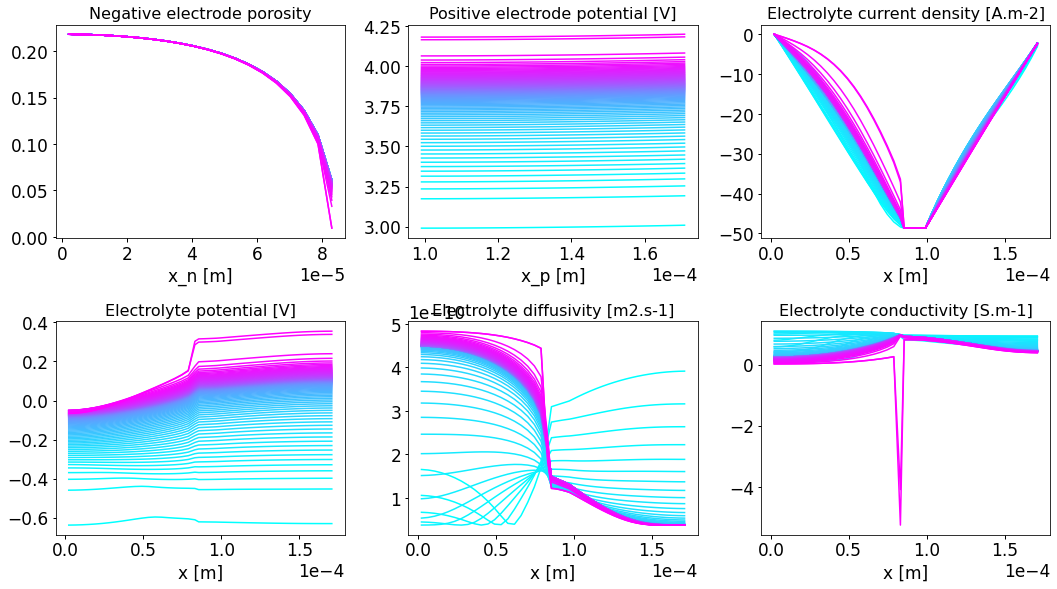

In [18]:
# Get dict and plot final single steps
index_cyc_All = []; # for each scan!
step_RPT_RE = -1
my_dict_AGE_all = [];Full_cycle_all = []
for i in range(0,len(Sol_All_All)):
    my_dict_AGE = {}; 
    for keys in keys_all_AGE:
        for key in keys:
            my_dict_AGE[key]=[];	
    if not os.path.exists(BasicPath + Target + f"{i}th Scan/"):
        os.mkdir(BasicPath + Target+  f"{i}th Scan/")
    Sol_all_i = Sol_All_All[i]
    Succ_Cyc_i = Succ_Cyc_All[i]
    Succ_Cyc_acc_i = np.cumsum(Succ_Cyc_i).tolist()
    Full_cycle = []
    # post-prosessing for full cycle range
    # prosess for the 1st solution: how many cycles do you have?
    if Index_single_step[i]<len(Sol_all_i):
        print("Not all solution has full cycles")
        for j in range(Index_single_step[i],len(Sol_all_i)):
            index_cyc = Succ_Cyc_acc_i[j];
            Plot_Last_Single_Step(
                Sol_all_i[j],0,0,BasicPath, 
                Target,i,index_cyc,"True","cool",17,200)

    for j in range(0,Index_single_step[i]):# post-prosess for normal full cycles
        if j == 0 and Succ_Cyc_acc_i[j]>1: # first solution:
            # get two solution
            cycle_no=0
            Full_cycle.append(0)
            my_dict_AGE_old = my_dict_AGE; del my_dict_AGE
            my_dict_AGE = GetSol_dict (
                my_dict_AGE_old,keys_all_AGE, Sol_all_i[j], 
                cycle_no, step_AGE_CD , step_AGE_CC , 
                step_RPT_RE, step_AGE_CV   ) 
                
            cycle_no=Succ_Cyc_i[j]-1
            Full_cycle.append(Succ_Cyc_acc_i[j])
            my_dict_AGE_old = my_dict_AGE; del my_dict_AGE
            my_dict_AGE = GetSol_dict (
                my_dict_AGE_old,keys_all_AGE, Sol_all_i[j], 
                cycle_no, step_AGE_CD , step_AGE_CC , 
                step_RPT_RE, step_AGE_CV   ) 
        else:
            # get only one solution
            cycle_no=Succ_Cyc_i[j]-1
            Full_cycle.append(Succ_Cyc_acc_i[j])
            my_dict_AGE_old = my_dict_AGE; del my_dict_AGE
            my_dict_AGE = GetSol_dict (
                my_dict_AGE_old,keys_all_AGE, Sol_all_i[j], 
                cycle_no, step_AGE_CD , step_AGE_CC , 
                step_RPT_RE, step_AGE_CV   ) 
    my_dict_AGE_all.append(my_dict_AGE)
    Full_cycle_all.append(Full_cycle)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

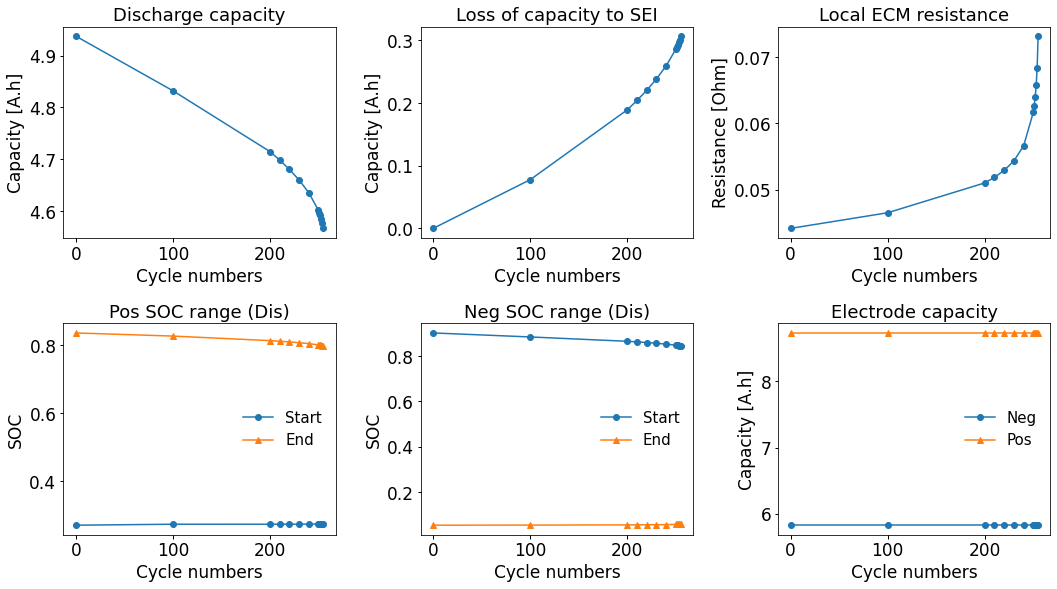

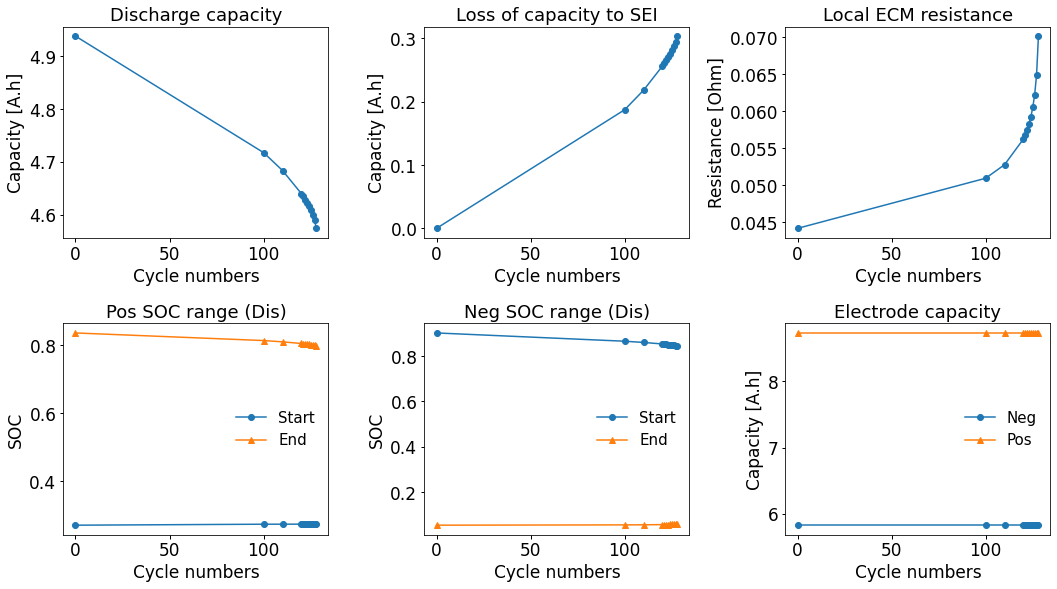

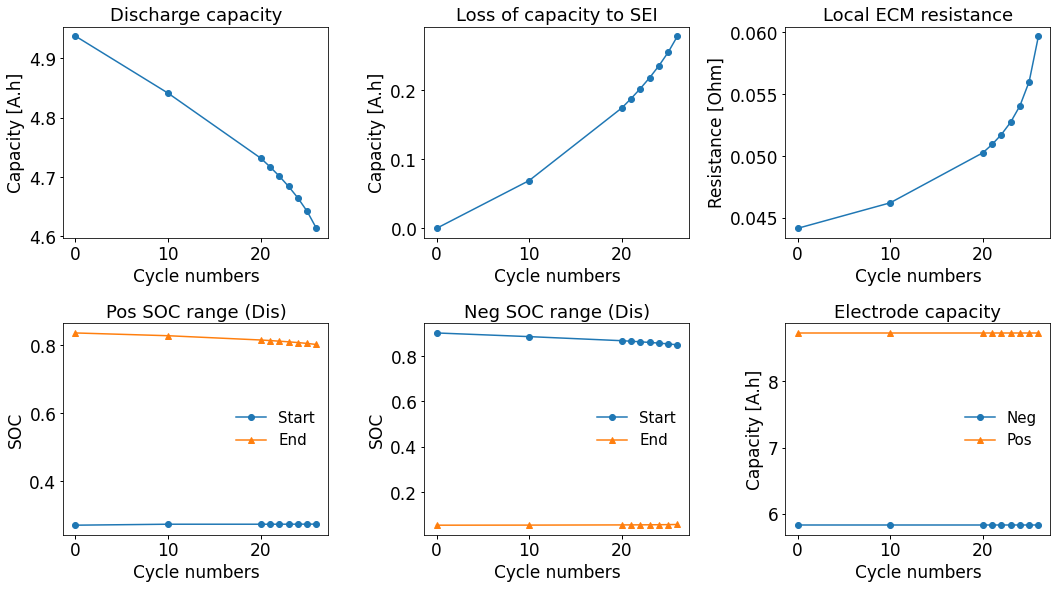

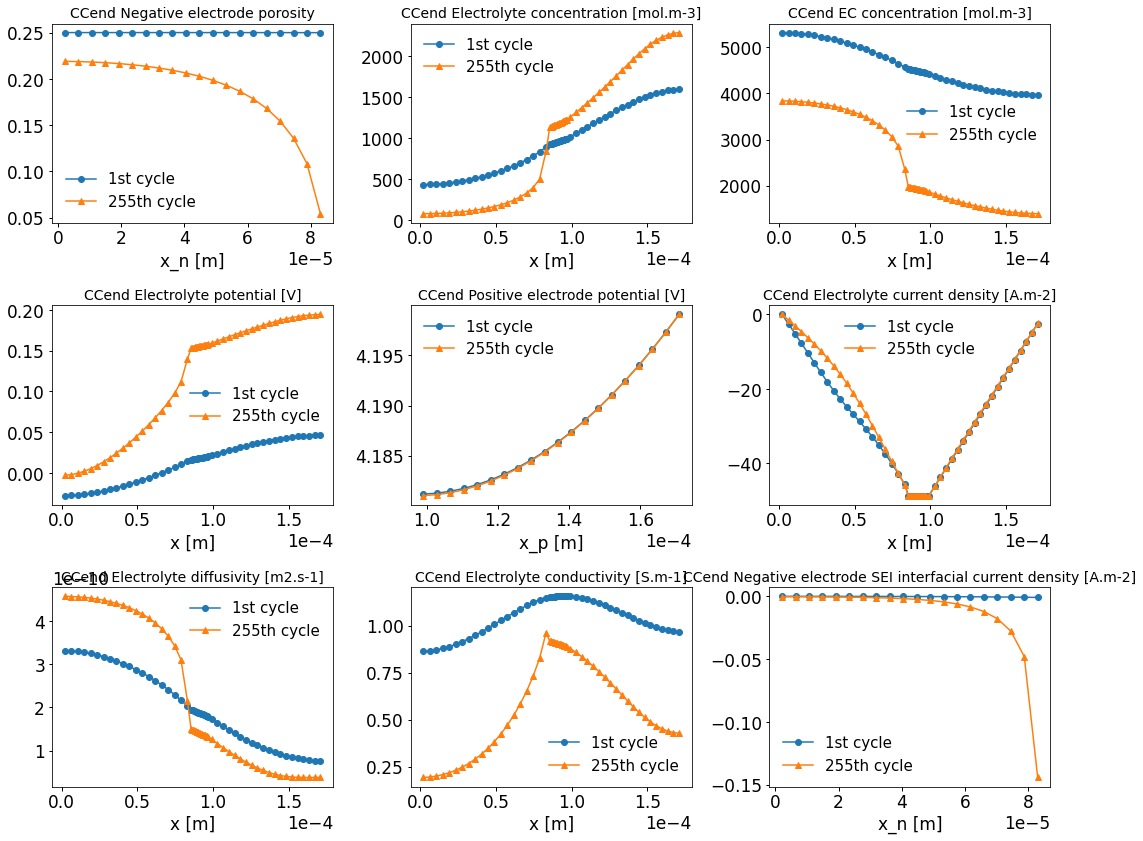

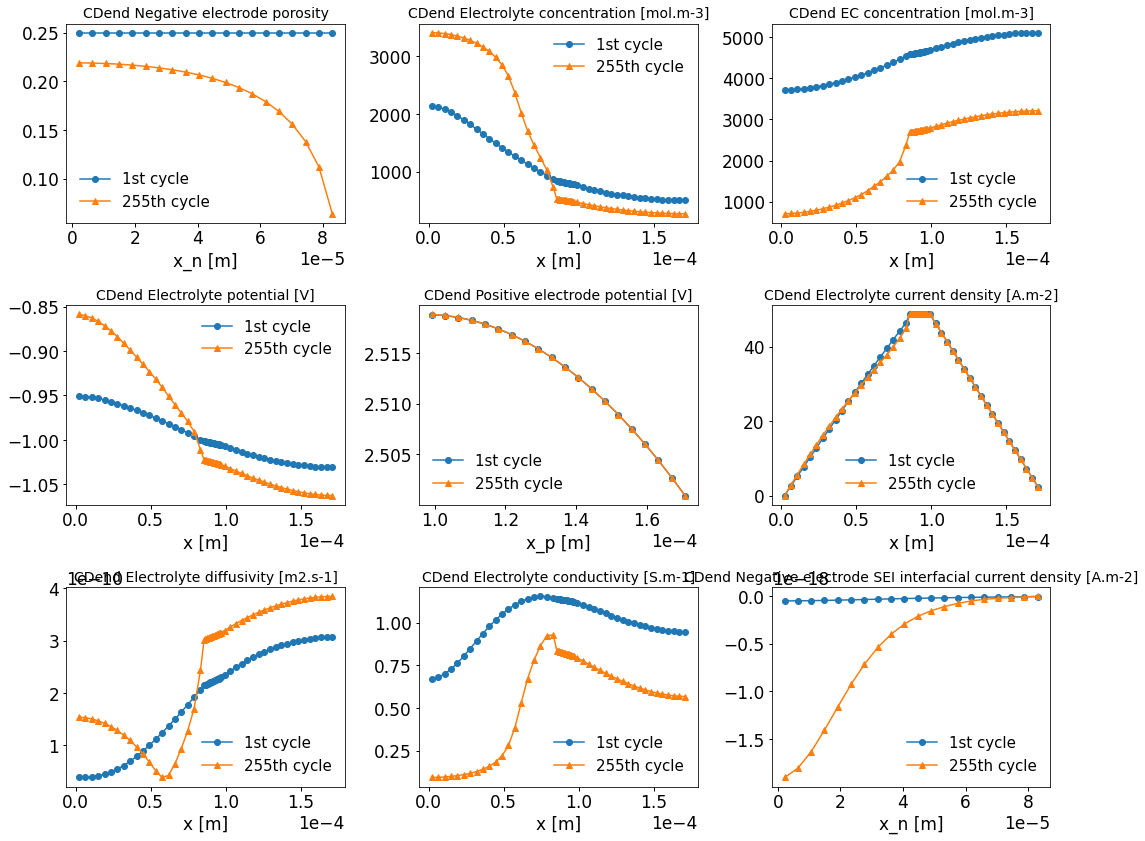

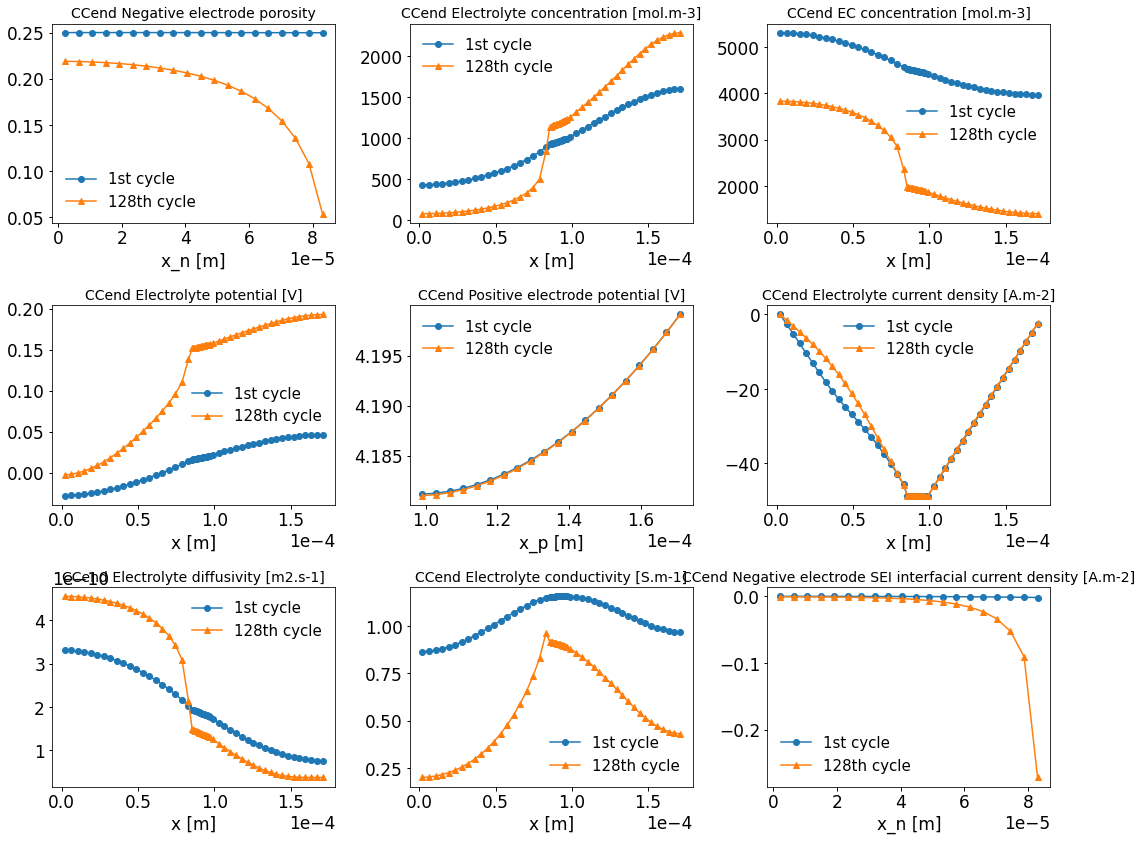

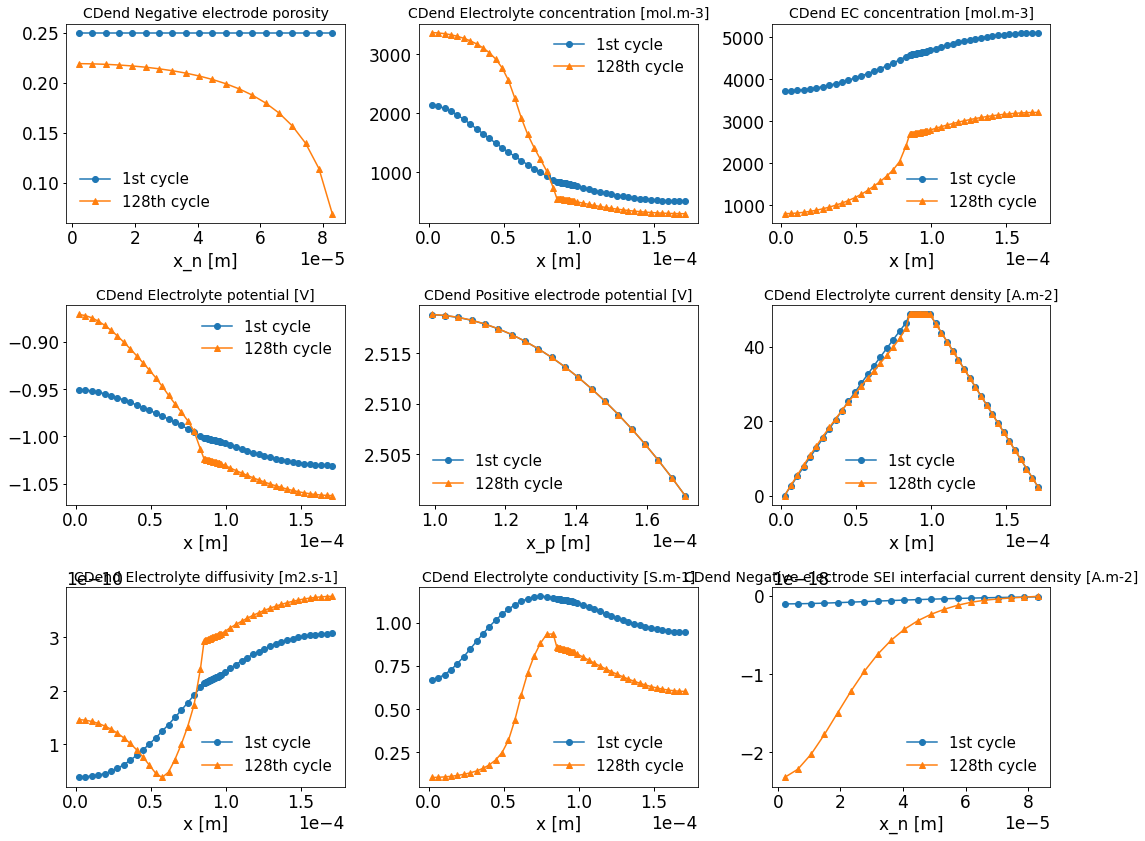

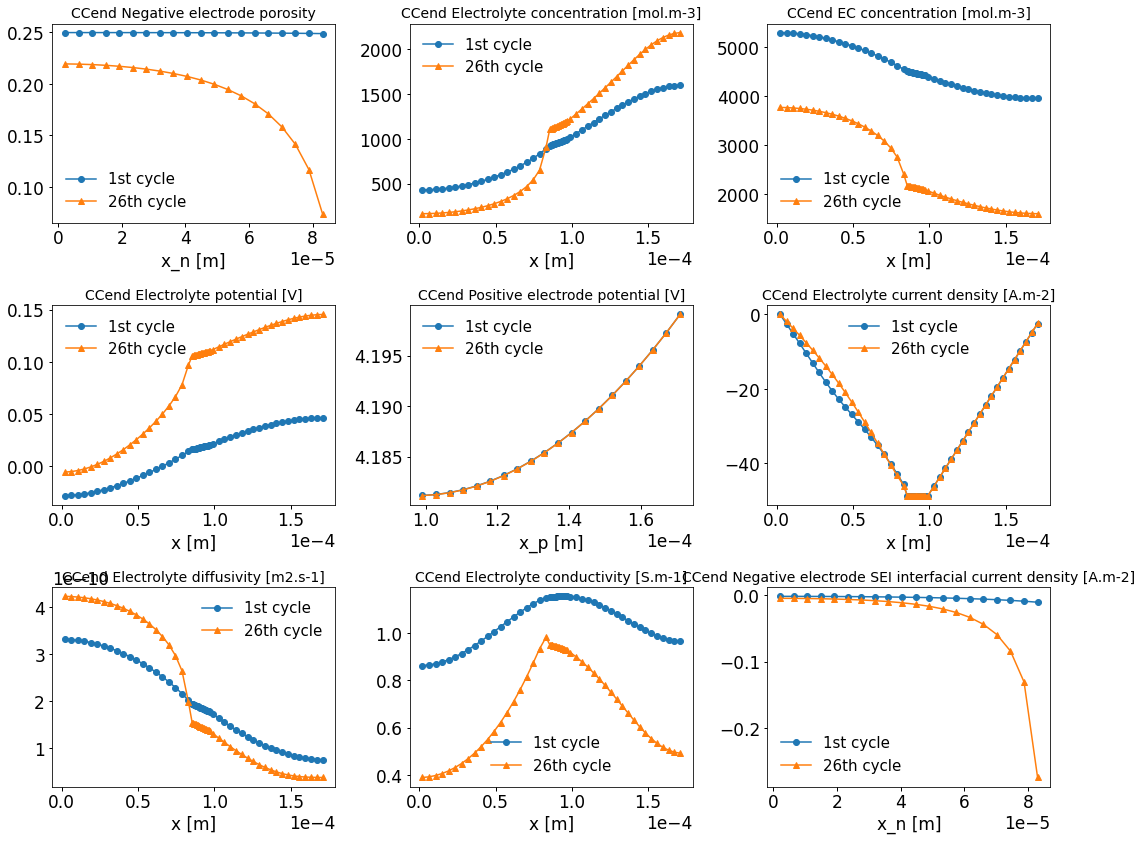

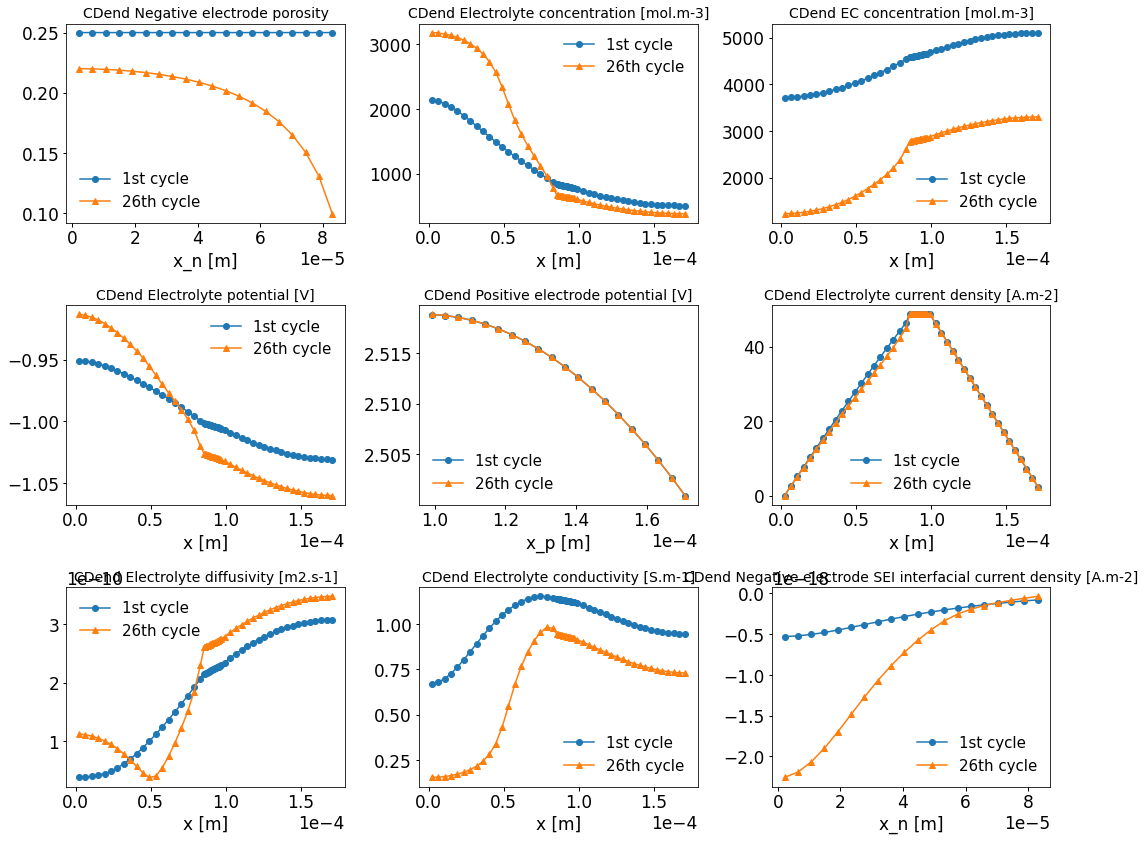

In [19]:
# Plot fig 1~3:
for i in range(0,len(Sol_All_All)):
    Plot_Fig_1(Full_cycle_all[i],my_dict_AGE_all[i],
        BasicPath, Target,   i,  17,  200)

key_all_CCend = [
    "CCend Negative electrode porosity",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend EC concentration [mol.m-3]",
    "CCend Electrolyte potential [V]",
    "CCend Positive electrode potential [V]",
    "CCend Electrolyte current density [A.m-2]",
    "CCend Electrolyte diffusivity [m2.s-1]",
    "CCend Electrolyte conductivity [S.m-1]",
    "CCend Negative electrode SEI interfacial current density [A.m-2]",
]
key_all_CDend = [
    "CDend Negative electrode porosity",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend EC concentration [mol.m-3]",
    "CDend Electrolyte potential [V]",
    "CDend Positive electrode potential [V]",
    "CDend Electrolyte current density [A.m-2]",
    "CDend Electrolyte diffusivity [m2.s-1]",
    "CDend Electrolyte conductivity [S.m-1]",
    "CDend Negative electrode SEI interfacial current density [A.m-2]",
]
for i in range(0,len(Sol_All_All)):
    fig, axs = Plot_Loc_Var_2(
        Full_cycle_all[i],key_all_CCend,my_dict_AGE_all[i],17)
    plt.savefig(
        BasicPath + Target+f"{i}th Scan/" +
        "Fig. 2 - CCend Loc based overall.png", dpi=300)
    fig, axs = Plot_Loc_Var_2(
        Full_cycle_all[i],key_all_CDend,my_dict_AGE_all[i],17)
    plt.savefig(
        BasicPath + Target+f"{i}th Scan/" +
        "Fig. 3 - CDend Loc based overall.png", dpi=300)

In [20]:
# write into excel:
for i in range(0,len(Sol_All_All)):
    Para_dict_old = Para_dict_list[i]
    str_exp_AGE_text = str(exp_AGE)

    value_list_temp = list(Para_dict_old.values())
    values = []
    for value_list_temp_i in value_list_temp:
        values.append(str(value_list_temp_i))
    values.insert(0,str(i));
    #"Cap Loss","LLI to SEI",
    #"LAM to Neg","LAM to Pos",
    #"Error"])
    values.extend([
        str_exp_AGE_text,
        str(my_dict_AGE_all[i]["Discharge capacity [A.h]"][0] 
        - 
        my_dict_AGE_all[i]["Discharge capacity [A.h]"][-1]),

        str(my_dict_AGE_all[i]["CDend Loss of capacity to SEI [A.h]"][-1]),
        str(my_dict_AGE_all[i]["CDend Negative electrode capacity [A.h]"][0] 
        - 
        my_dict_AGE_all[i]["CDend Negative electrode capacity [A.h]"][-1]),

        str(my_dict_AGE_all[i]["CDend Positive electrode capacity [A.h]"][0] 
        - 
        my_dict_AGE_all[i]["CDend Positive electrode capacity [A.h]"][-1]),
    ])
    values = [values,]
    book_name_xlsx_seperate =   str(i)+ '_' + book_name_xlsx;
    sheet_name_xlsx =  str(i);
    write_excel_xlsx(
        BasicPath + Target+   book_name_xlsx_seperate, 
        sheet_name_xlsx, values)

Successfully create a excel file
Successfully create a excel file
Successfully create a excel file


In [21]:
# Write all seperate excel files into a big file:
for i in range(0,len(Sol_All_All)):
    #print(index_list_i)
    old_book = str(i) + '_' + book_name_xlsx
    #print(old_book)
    #open excel:
    data_old = openpyxl.load_workbook(BasicPath + Target + old_book)   
    data_tar = openpyxl.load_workbook(BasicPath + Target + book_name_xlsx) 

    table_old = data_old.get_sheet_by_name(str(i))
    nrows_old = table_old.max_row  # 获得行数
    ncolumns_old = table_old.max_column  # 获得列数

    tar_sheet_name_xlsx = 'Results';
    table_tar = data_tar.get_sheet_by_name(tar_sheet_name_xlsx)
    nrows_tar = table_tar.max_row  # 获得行数
    ncolumns_old = table_old.max_column  # 获得列数
    list_old = [];
    #print(nrows_old,nrows_tar)
    for i in range(1,nrows_old+1):
        for j in range(1,ncolumns_old+1):
            list_old.append(table_old.cell(row=i,column=j).value)
    
    list_old = [list_old,]
    for i in range(1, len(list_old)+1):
            for j in range(1, len(list_old[i-1])+1):
                #print(i,j,list_old[i-1][j-1]    )
                table_tar.cell(nrows_tar+i, j).value = list_old[i-1][j-1]     
    data_tar.save(BasicPath + Target + book_name_xlsx) 
    data_tar.close()


